In [53]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import keras

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
yAll=yAll/25.0

In [3]:
y=yAll.sel(time=slice('1980-1-1','2014-12-31'))

In [4]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')

In [5]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [7]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [8]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [9]:
# AO Input
AOData1 = xr.open_dataset('../../../Data/AO_EU/AO_Calculated.nc')
print(AOData1)

Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(AOData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), AOData1.AO[t].values)

<xarray.Dataset>
Dimensions:  (time: 3772)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Data variables:
    AO       (time) float32 ...


In [10]:
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})

In [11]:
print(AOData1.AO.sel(time='2018-12-10'))
print(AOData.AO.sel(time='2018-12-10'))

<xarray.DataArray 'AO' (time: 1)>
array([0.668036], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-12-10T09:00:00
<xarray.DataArray 'AO' (time: 1, latitude: 46, longitude: 180)>
array([[[0.66803634, 0.66803634, 0.66803634, ..., 0.66803634,
         0.66803634, 0.66803634],
        [0.66803634, 0.66803634, 0.66803634, ..., 0.66803634,
         0.66803634, 0.66803634],
        [0.66803634, 0.66803634, 0.66803634, ..., 0.66803634,
         0.66803634, 0.66803634],
        ...,
        [0.66803634, 0.66803634, 0.66803634, ..., 0.66803634,
         0.66803634, 0.66803634],
        [0.66803634, 0.66803634, 0.66803634, ..., 0.66803634,
         0.66803634, 0.66803634],
        [0.66803634, 0.66803634, 0.66803634, ..., 0.66803634,
         0.66803634, 0.66803634]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-12-10T09:00:00
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 

In [12]:
#EU Input
EUData1 = xr.open_dataset('../../../Data/AO_EU/EU_NovDecJan.nc')

In [13]:
EUData1.EUVal

<xarray.DataArray 'EUVal' (time: 3772)>
array([-0.399895,  0.098971,  0.588636, ..., -0.491086, -0.850494, -0.49535 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    average_op_ncl:  dim_avg_n over dimension(s): latitude,longitude
    units:           m**2 s**-2
    long_name:       Geopotential
    standard_name:   geopotential

In [14]:
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(EUData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), EUData1.EUVal[t].values)

In [15]:
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})

In [16]:
#print(EUData1.EUVal.sel(time='1980-12-10'))
#print(EUData.EU.sel(time='1980-12-10'))

In [17]:
print(EUData1.EUVal.sel(time='1980-12-10'))
print(EUData.EU.sel(time='1980-12-10'))

<xarray.DataArray 'EUVal' (time: 1)>
array([0.5669], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-10T09:00:00
Attributes:
    average_op_ncl:  dim_avg_n over dimension(s): latitude,longitude
    units:           m**2 s**-2
    long_name:       Geopotential
    standard_name:   geopotential
<xarray.DataArray 'EU' (time: 1, latitude: 46, longitude: 180)>
array([[[0.56689954, 0.56689954, 0.56689954, ..., 0.56689954,
         0.56689954, 0.56689954],
        [0.56689954, 0.56689954, 0.56689954, ..., 0.56689954,
         0.56689954, 0.56689954],
        [0.56689954, 0.56689954, 0.56689954, ..., 0.56689954,
         0.56689954, 0.56689954],
        ...,
        [0.56689954, 0.56689954, 0.56689954, ..., 0.56689954,
         0.56689954, 0.56689954],
        [0.56689954, 0.56689954, 0.56689954, ..., 0.56689954,
         0.56689954, 0.56689954],
        [0.56689954, 0.56689954, 0.56689954, ..., 0.56689954,
         0.56689954, 0.56689954]]])
Coordinates:
  * time       

In [18]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)
ao=AOData.AO.shift(time=1)
eu=EUData.EU.shift(time=1)

In [19]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
aoTsAll=ao[((ao.time.dt.month>11) | (ao.time.dt.month<2)) & (ao.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
euTsAll=eu[((eu.time.dt.month>11) | (eu.time.dt.month<2)) & (eu.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [20]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=aoTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
aoTsAll.values=t1.unstack()

t1=euTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
euTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [21]:
t2mTs=t2mTsAll.sel(time=slice('1980-1-1','2014-12-31'))
wsTs=wsTsAll.sel(time=slice('1980-1-1','2014-12-31'))
rhTs=rhTsAll.sel(time=slice('1980-1-1','2014-12-31'))
invTs=invTsAll.sel(time=slice('1980-1-1','2014-12-31'))
wTs=wTsAll.sel(time=slice('1980-1-1','2014-12-31'))
ushearTs=ushearTsAll.sel(time=slice('1980-1-1','2014-12-31'))
aoTs=aoTsAll.sel(time=slice('1980-1-1','2014-12-31'))
euTs=euTsAll.sel(time=slice('1980-1-1','2014-12-31'))

In [22]:
t2m_train,t2m_test,ws_train,ws_test,rh_train,rh_test,inv_train,inv_test, w_train, w_test,ushear_train, ushear_test,ao_train,ao_test,eu_train,eu_test,y_train,y_test= train_test_split( t2mTs,wsTs,rhTs,invTs, wTs,ushearTs,aoTs,euTs,y,test_size=0.20, random_state=0)

In [23]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape


wstrain=ws_train.values
wstrain=wstrain[:,:,:,None]
wstrain.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape


invtrain=inv_train.values
invtrain=invtrain[:,:,:,None]
invtrain.shape

wtrain=w_train.values
wtrain=wtrain[:,:,:,None]
wtrain.shape

usheartrain=ushear_train.values
usheartrain=usheartrain[:,:,:,None]
usheartrain.shape

aotrain=ao_train.values
aotrain=aotrain[:,:,:,None]
aotrain.shape

eutrain=eu_train.values
eutrain=eutrain[:,:,:,None]
eutrain.shape

(1736, 18, 26, 1)

In [24]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape


wstest=ws_test.values
wstest=wstest[:,:,:,None]
wstest.shape

rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape


invtest=inv_test.values
invtest=invtest[:,:,:,None]
invtest.shape

wtest=w_test.values
wtest=wtest[:,:,:,None]
wtest.shape

usheartest=ushear_test.values
usheartest=usheartest[:,:,:,None]
usheartest.shape

aotest=ao_test.values
aotest=aotest[:,:,:,None]
aotest.shape

eutest=eu_test.values
eutest=eutest[:,:,:,None]
eutest.shape

(434, 18, 26, 1)

In [25]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

In [26]:
#X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test=np.array([rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

#X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
X_train.shape

(7, 1736, 18, 26, 1)

In [27]:
X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

(434, 7, 18, 26, 1)

Epoch 1/20
55/55 [==============================] - 9s 150ms/step - loss: 0.3243 - accuracy: 0.0514 - val_loss: 0.1689 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 8s 149ms/step - loss: 0.1649 - accuracy: 0.0566 - val_loss: 0.1421 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 8s 144ms/step - loss: 0.1314 - accuracy: 0.0557 - val_loss: 0.1290 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 8s 143ms/step - loss: 0.1183 - accuracy: 0.0534 - val_loss: 0.1266 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 8s 144ms/step - loss: 0.1070 - accuracy: 0.0534 - val_loss: 0.1178 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 8s 145ms/step - loss: 0.1015 - accuracy: 0.0453 - val_loss: 0.1153 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 8s 144ms/step - loss: 0.1043 - accuracy: 0.0587 - val_loss: 0.1102 - val_accuracy: 0.0691
Epoch 

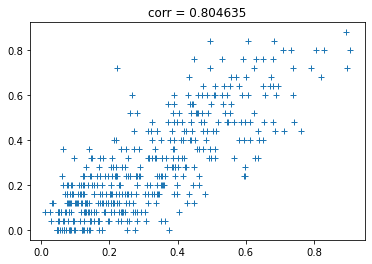

In [54]:
model = Sequential()

model.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(MaxPooling3D(pool_size=2,padding='same'))
model.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2,padding='same'))

model.add(Flatten())

model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')


In [55]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 7, 18, 26, 8)      224       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 4, 9, 13, 8)       0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 4, 9, 13, 16)      16016     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 2, 5, 7, 16)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1120)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 120)               134520    
_________________________________________________________________
dense_18 (Dense)             (None, 84)               

Epoch 1/20
55/55 [==============================] - 30s 536ms/step - loss: 0.2965 - accuracy: 0.0469 - val_loss: 0.1662 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 29s 525ms/step - loss: 0.1606 - accuracy: 0.0542 - val_loss: 0.1371 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 29s 529ms/step - loss: 0.1315 - accuracy: 0.0561 - val_loss: 0.1572 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 30s 550ms/step - loss: 0.1341 - accuracy: 0.0441 - val_loss: 0.1182 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 29s 537ms/step - loss: 0.1029 - accuracy: 0.0559 - val_loss: 0.1105 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 28s 519ms/step - loss: 0.0927 - accuracy: 0.0480 - val_loss: 0.1121 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 29s 524ms/step - loss: 0.0929 - accuracy: 0.0467 - val_loss: 0.1036 - val_accuracy: 0.0691

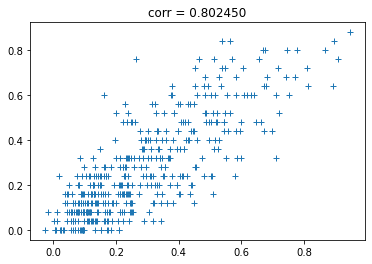

In [56]:
model1 = Sequential()
model1.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model1.add(MaxPooling3D(pool_size=2,padding='same'))
model1.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model1.add(MaxPooling3D(pool_size=2,padding='same'))
model1.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
model1.add(MaxPooling3D(pool_size=2,padding='same'))

model1.add(Flatten())

model1.add(Dense(64, activation='relu'))
model1.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
model1.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model1.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model1.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
model1.summary()

Epoch 1/20
55/55 [==============================] - 22s 390ms/step - loss: 0.3419 - accuracy: 0.0428 - val_loss: 0.1704 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 22s 405ms/step - loss: 0.1654 - accuracy: 0.0510 - val_loss: 0.1782 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 21s 378ms/step - loss: 0.1813 - accuracy: 0.0580 - val_loss: 0.1665 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 21s 388ms/step - loss: 0.1565 - accuracy: 0.0591 - val_loss: 0.1380 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 21s 378ms/step - loss: 0.1257 - accuracy: 0.0507 - val_loss: 0.1218 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 21s 384ms/step - loss: 0.1034 - accuracy: 0.0531 - val_loss: 0.1149 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 20s 365ms/step - loss: 0.0957 - accuracy: 0.0576 - val_loss: 0.1064 - val_accuracy: 0.0691

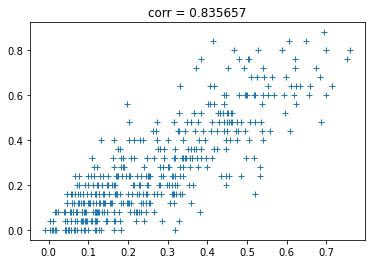

In [61]:
model2 = Sequential()
model2.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model2.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
model2.add(MaxPooling3D(pool_size=2, padding='same'))
model2.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model2.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model2.add(MaxPooling3D(pool_size=2,padding='same'))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model2.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model2.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
model2.summary()

Epoch 1/20
55/55 [==============================] - 3s 49ms/step - loss: 0.1999 - accuracy: 0.0586 - val_loss: 0.1708 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 3s 48ms/step - loss: 0.1676 - accuracy: 0.0510 - val_loss: 0.1711 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 3s 48ms/step - loss: 0.1563 - accuracy: 0.0540 - val_loss: 0.1554 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 3s 47ms/step - loss: 0.1498 - accuracy: 0.0482 - val_loss: 0.1470 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 2s 44ms/step - loss: 0.1260 - accuracy: 0.0549 - val_loss: 0.1237 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 3s 51ms/step - loss: 0.1117 - accuracy: 0.0505 - val_loss: 0.1149 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 3s 47ms/step - loss: 0.1081 - accuracy: 0.0544 - val_loss: 0.1063 - val_accuracy: 0.0691
Epoch 8/20
55

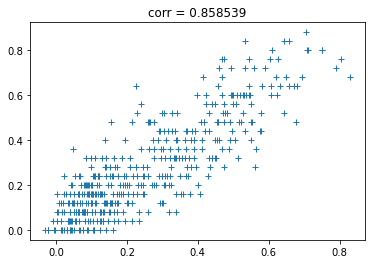

In [62]:
model_av = Sequential()

model_av.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model_av.add(AveragePooling3D(pool_size=2,padding='same'))
model_av.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
model_av.add(AveragePooling3D(pool_size=2,padding='same'))

model_av.add(Flatten())

model_av.add(Dense(120, activation='relu'))
model_av.add(Dense(84, activation='relu'))
model_av.add(Dense(10, activation='relu'))
model_av.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
model_av.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model_av.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model_av.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
model_av.summary()

Epoch 1/20
55/55 [==============================] - 6s 93ms/step - loss: 0.1912 - accuracy: 0.0536 - val_loss: 0.1685 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 5s 94ms/step - loss: 0.1670 - accuracy: 0.0486 - val_loss: 0.1625 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 5s 89ms/step - loss: 0.1623 - accuracy: 0.0533 - val_loss: 0.1396 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 5s 88ms/step - loss: 0.1343 - accuracy: 0.0562 - val_loss: 0.1238 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 4s 80ms/step - loss: 0.1203 - accuracy: 0.0552 - val_loss: 0.1183 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 5s 85ms/step - loss: 0.1114 - accuracy: 0.0621 - val_loss: 0.1176 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 5s 87ms/step - loss: 0.1078 - accuracy: 0.0531 - val_loss: 0.1138 - val_accuracy: 0.0691
Epoch 8/20
55

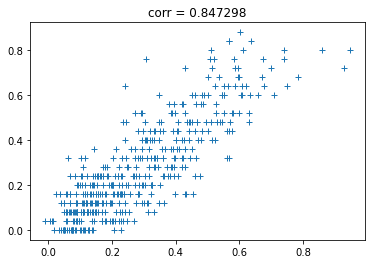

In [63]:
model1_av = Sequential()
model1_av.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model1_av.add(AveragePooling3D(pool_size=2,padding='same'))
model1_av.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model1_av.add(AveragePooling3D(pool_size=2,padding='same'))
model1_av.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
model1_av.add(AveragePooling3D(pool_size=2,padding='same'))

model1_av.add(Flatten())

model1_av.add(Dense(64, activation='relu'))
model1_av.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
model1_av.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model1_av.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model1_av.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
model1_av.summary()

Epoch 1/20
55/55 [==============================] - 9s 147ms/step - loss: 0.2286 - accuracy: 0.0510 - val_loss: 0.1697 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 8s 141ms/step - loss: 0.1703 - accuracy: 0.0540 - val_loss: 0.1726 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 8s 147ms/step - loss: 0.1659 - accuracy: 0.0516 - val_loss: 0.1685 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 8s 147ms/step - loss: 0.1538 - accuracy: 0.0499 - val_loss: 0.1349 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 8s 145ms/step - loss: 0.1258 - accuracy: 0.0506 - val_loss: 0.1134 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 8s 150ms/step - loss: 0.1055 - accuracy: 0.0542 - val_loss: 0.1020 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 8s 147ms/step - loss: 0.0942 - accuracy: 0.0608 - val_loss: 0.1037 - val_accuracy: 0.0691
Epoch 

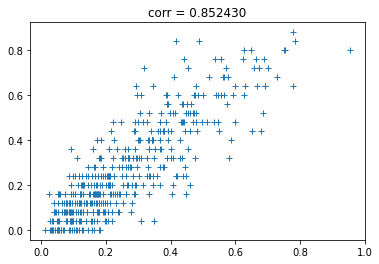

In [65]:
model2_av = Sequential()
model2_av.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model2_av.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
model2_av.add(AveragePooling3D(pool_size=2,padding='same'))
model2_av.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model2_av.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model2_av.add(AveragePooling3D(pool_size=2,padding='same'))

model2_av.add(Flatten())

model2_av.add(Dense(512, activation='relu'))
model2_av.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
model2_av.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model2_av.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model2_av.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
model2_av.summary()

In [66]:
X_train

array([[[[[-0.95394713],
          [-1.06075287],
          [-0.9141463 ],
          ...,
          [ 1.33783329],
          [ 1.72565997],
          [ 1.58103812]],

         [[-0.11517869],
          [ 0.73614985],
          [-0.00747112],
          ...,
          [ 1.024454  ],
          [ 0.54028261],
          [ 0.89460546]],

         [[-0.55158001],
          [-0.19133516],
          [ 0.44872653],
          ...,
          [ 0.8907848 ],
          [ 1.20016801],
          [ 1.24725056]],

         ...,

         [[ 1.90732729],
          [ 1.40017891],
          [ 1.37705612],
          ...,
          [-2.74114251],
          [ 1.25631845],
          [ 1.27556443]],

         [[ 1.20808041],
          [ 0.83866554],
          [ 1.53037274],
          ...,
          [-0.53412551],
          [-0.66925514],
          [ 2.19014525]],

         [[ 0.28059155],
          [ 0.54487419],
          [ 0.27346772],
          ...,
          [-0.22360466],
          [-0.97111917],
          

In [68]:
X_ttrain, X_vval, y_ttrain, y_vval = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)


ValueError: Found input variables with inconsistent numbers of samples: [7, 1736]

In [ ]:
def data():
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)
    return X_train, Y_train, X_val, Y_val

# Test Data

In [29]:
t2mTst=t2mTsAll.sel(time=slice('2015-1-1','2018-12-31'))
wsTst=wsTsAll.sel(time=slice('2015-1-1','2018-12-31'))
rhTst=rhTsAll.sel(time=slice('2015-1-1','2018-12-31'))
invTst=invTsAll.sel(time=slice('2015-1-1','2018-12-31'))
wTst=wTsAll.sel(time=slice('2015-1-1','2018-12-31'))
ushearTst=ushearTsAll.sel(time=slice('2015-1-1','2018-12-31'))
aoTst=aoTsAll.sel(time=slice('2015-1-1','2018-12-31'))
euTst=euTsAll.sel(time=slice('2015-1-1','2018-12-31'))
yt=yAll.sel(time=slice('2015-1-1','2018-12-31'))

In [30]:
t2m_t=t2mTst.values
t2m_t=t2m_t[:,:,:,None]
t2m_t.shape


ws_t=wsTst.values
ws_t=ws_t[:,:,:,None]
ws_t.shape

rh_t=rhTst.values
rh_t=rh_t[:,:,:,None]
rh_t.shape


inv_t=invTst.values
inv_t=inv_t[:,:,:,None]
inv_t.shape

w_t=wTst.values
w_t=w_t[:,:,:,None]
w_t.shape

ushear_t=ushearTst.values
ushear_t=ushear_t[:,:,:,None]
ushear_t.shape

ao_t=aoTst.values
ao_t=ao_t[:,:,:,None]
ao_t.shape

eu_t=euTst.values
eu_t=eu_t[:,:,:,None]
eu_t.shape

(248, 18, 26, 1)

In [31]:
#X_t=np.array([t2m_t,rh_t,ws_t,inv_t,w_t,ushear_t,ao_t,eu_t])
X_t=np.array([rh_t,ws_t,inv_t,w_t,ushear_t,ao_t,eu_t])
X_t.shape


(7, 248, 18, 26, 1)

In [32]:
X_t_reshape = np.einsum('lkija->klija',X_t)
X_t_reshape.shape

(248, 7, 18, 26, 1)

In [33]:
yLRt=model.predict(X_t_reshape)

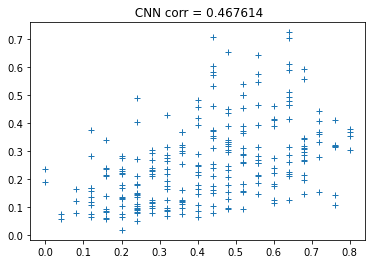

In [34]:
testcorr = np.corrcoef(yLRt[:,0],yt)[0,1]

#acc_svr       = round(regLin.score(Xt, yt) * 100, 2)

#print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)

plt.title(' CNN corr = %f'%testcorr)

plt.plot(yt,yLRt[:,0],'+')


In [35]:
# Fog STat

In [36]:
t2mAll=t2mTs.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTs.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTs.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTs.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTs.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTs.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape

aoAll=aoTs.values
aoAll=aoAll[:,:,:,None]
aoAll.shape

euAll=euTs.values
euAll=euAll[:,:,:,None]
euAll.shape

(2170, 18, 26, 1)

In [37]:
X_All=np.array([rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll])
X_All.shape

X_All_reshape = np.einsum('lkija->klija',X_All)
X_All_reshape.shape

(2170, 7, 18, 26, 1)

In [38]:
yLR=model.predict(X_All_reshape)

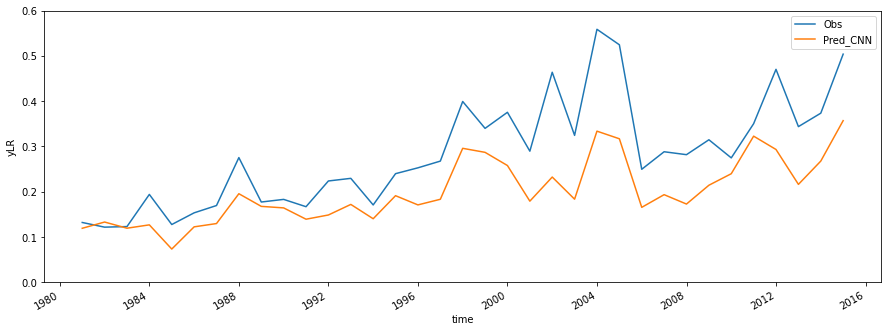

In [39]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR[:,0])}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataCNN_1.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_CNN')
#dump(y,'TS1dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()


In [40]:
ynf=y.where(y<0.040, drop=True)
print(ynf.shape[0])

yint1=y.where(y>=0.04,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
print(yintf.shape[0])

yWd=y.where(y>=0.48, drop=True)
print(yWd.shape[0])

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
print(yLRnf.yLR.shape[0])

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>=0.04,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)
print(yLRintf.yLR.shape[0])

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>=0.48,drop=True)
print(yLRWd.yLR.shape[0])

print((ynf.shape[0]+yintf.shape[0]+yWd.shape[0]))
print((yLRnf.yLR.shape[0]+yLRintf.yLR.shape[0]+yLRWd.yLR.shape[0]))

123
1569
478
145
1908
117
2170
2170


Text(0.5, 1.0, 'CNN')

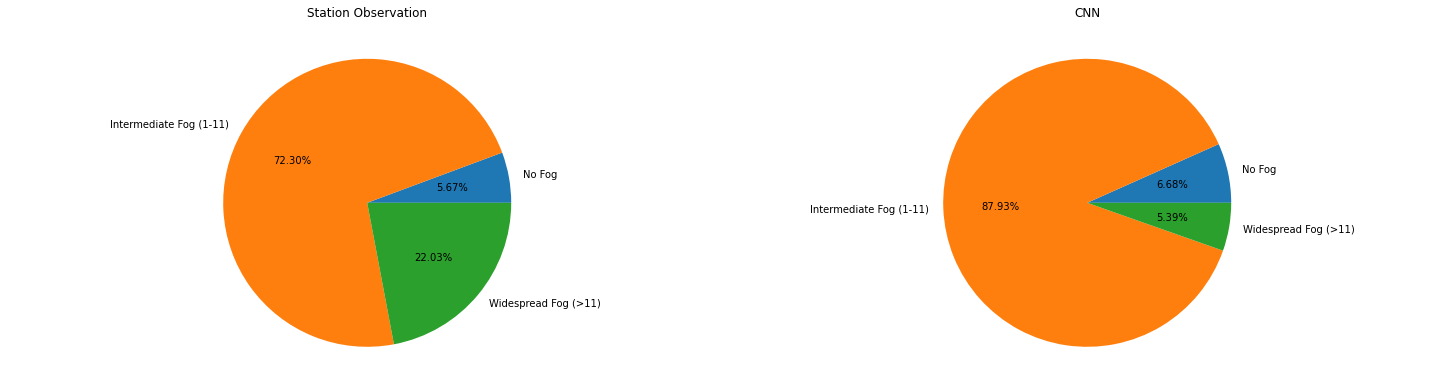

In [41]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')

In [42]:
pie1dataObs = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
pie1dataLR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
#dump(pie1dataObs, 'pie1dataObs_1.joblib') 
dump(pie1dataLR,'pie1dataCNN_1.joblib')

['pie1dataCNN_1.joblib']

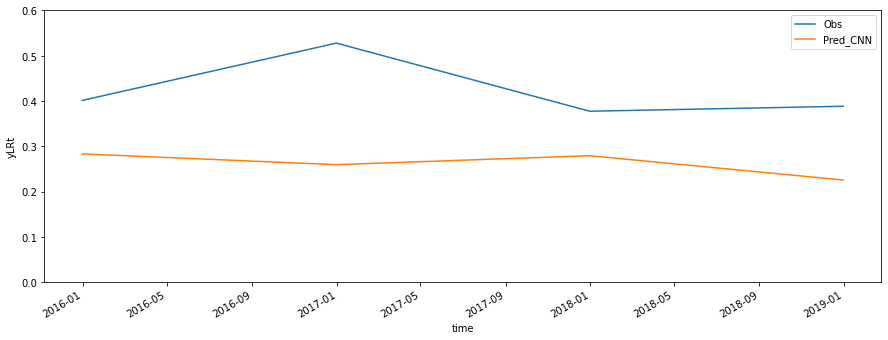

In [43]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt[:,0])}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataCNN_1.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_CNN')
##dump(yt,'TS2dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()

In [44]:
ynft=yt.where(yt<0.040, drop=True)
print(ynft.shape[0])

yint1t=yt.where(yt>=0.04,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
print(yintft.shape[0])

yWdt=yt.where(yt>=0.48, drop=True)
print(yWdt.shape[0])

print((ynft.shape[0]+yintft.shape[0]+yWdt.shape[0]))

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)
print(yLRnft.yLRt.shape[0])

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>=0.04,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
print(yLRintft.yLRt.shape[0])

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>=0.48,drop=True)
print(yLRWdt.yLRt.shape[0])

print((yLRnft.yLRt.shape[0]+yLRintft.yLRt.shape[0]+yLRWdt.yLRt.shape[0]))

2
136
110
248
1
225
22
248


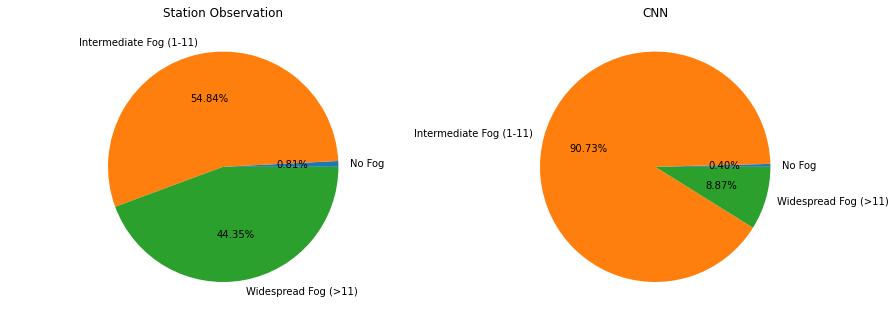

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')
plt.show()

In [46]:
pie1dataObs = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
pie1dataLR = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
#dump(pie1dataObs, 'pie2dataObs_1.joblib') 
dump(pie1dataLR,'pie2dataCNN_1.joblib')

['pie2dataCNN_1.joblib']